<a href="https://colab.research.google.com/github/abunchoftigers/Prediction-of-Product-Sales/blob/main/LogReg%2C_Random_Forest%2C_or_KNN_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LogReg, Random Forest, or KNN (Core)

Author: David Dyer

# First

## Imports & Data

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
# from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn import set_config
set_config(transform_output='pandas')

from google.colab import drive
import warnings

warnings.simplefilter('ignore')

In [65]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [66]:
fpath = '/content/drive/MyDrive/Coding Dojo - Data Science/02 - Intro to Machine Learning/Data/stroke.csv'
df = pd.read_csv(fpath)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1192,Female,31,0,0,No,Govt_job,Rural,70.66,27.2,never smoked,0
1,77,Female,13,0,0,No,children,Rural,85.81,18.6,Unknown,0
2,59200,Male,18,0,0,No,Private,Urban,60.56,33.0,never smoked,0
3,24905,Female,65,0,0,Yes,Private,Urban,205.77,46.0,formerly smoked,1
4,24257,Male,4,0,0,No,children,Rural,90.42,16.2,Unknown,0


## Helpers

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict





In [68]:
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [69]:
def plot_cv_results(gs, param_name='param_logisticregression__C', logx = True):
    # Making a dataframe with cv_results_
  cv_results = pd.DataFrame(gs.cv_results_)
  # Save the train/test scores with values for C
  scores = cv_results[[param_name,'mean_train_score','mean_test_score']]
  scores = scores.set_index(param_name)
  ## Plot the training vs test scores vs. C
  ax = scores.plot(y=['mean_test_score','mean_train_score'],
              style='o-',logx=logx)
  ax.set(ylabel=gs.scoring)
  print(scores['mean_test_score'])
  return ax

## Prepare the Data


1. Check for class balance with value_counts

In [70]:
df.stroke.value_counts

<bound method IndexOpsMixin.value_counts of 0       0
1       0
2       0
3       1
4       0
       ..
1132    0
1133    0
1134    0
1135    1
1136    0
Name: stroke, Length: 1137, dtype: int64>

In [71]:
try:
  df = df.drop(columns='id')
except:
  print('id col already dropped!')

In [72]:
df.select_dtypes('number').value_counts()

hypertension  heart_disease  avg_glucose_level  bmi   stroke
0             0              89.68              38.7  0         2
                             96.84              30.2  0         2
                             55.27              32.5  0         1
                             114.84             18.3  0         1
                             115.52             33.9  0         1
                                                               ..
                             84.79              24.2  0         1
                                                32.8  0         1
                             84.85              24.7  0         1
                             84.86              22.8  0         1
1             1              250.89             28.1  1         1
Length: 1083, dtype: int64

### Clean the Data

In [73]:
for col in df.columns:
  print(col, '\n', df[col].value_counts(), '\n')

gender 
 Female    642
Male      494
Other       1
Name: gender, dtype: int64 

age 
 79     26
57     24
78     24
52     23
81     22
       ..
3       7
35      7
12      6
4       6
*82     1
Name: age, Length: 84, dtype: int64 

hypertension 
 0    1002
1     135
Name: hypertension, dtype: int64 

heart_disease 
 0    1059
1      78
Name: heart_disease, dtype: int64 

ever_married 
 Yes    769
No     368
Name: ever_married, dtype: int64 

work_type 
 Private          672
Self-employed    174
children         147
Govt_job         142
Never_worked       2
Name: work_type, dtype: int64 

Residence_type 
 Urban    587
Rural    550
Name: Residence_type, dtype: int64 

avg_glucose_level 
 92.14     3
94.92     2
203.81    2
72.09     2
76.12     2
         ..
190.13    1
232.81    1
100.09    1
114.76    1
108.61    1
Name: avg_glucose_level, Length: 1069, dtype: int64 

bmi 
 27.3    11
31.4    11
26.1    11
28.7    11
35.9    11
        ..
54.6     1
45.5     1
44.5     1
46.1     1
4

In [74]:
df.age = df.age.replace('*82', 82).astype(np.int)

df.age.describe()

count    1137.000000
mean       45.189094
std        23.070207
min         0.000000
25%        28.000000
50%        48.000000
75%        63.000000
max        82.000000
Name: age, dtype: float64

In [75]:
df.avg_glucose_level.describe()

count    1137.000000
mean      107.664002
std        47.618723
min        55.270000
25%        77.600000
50%        91.820000
75%       113.850000
max       266.590000
Name: avg_glucose_level, dtype: float64

In [76]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Female,31,0,0,No,Govt_job,Rural,70.66,27.2,never smoked,0
1,Female,13,0,0,No,children,Rural,85.81,18.6,Unknown,0
2,Male,18,0,0,No,Private,Urban,60.56,33.0,never smoked,0
3,Female,65,0,0,Yes,Private,Urban,205.77,46.0,formerly smoked,1
4,Male,4,0,0,No,children,Rural,90.42,16.2,Unknown,0


3. Build and fit a model pipeline with the preprocessor and a default decisiontreeclassifer (use a random_state of 42)

In [77]:
df[['gender']].value_counts()

gender
Female    642
Male      494
Other       1
dtype: int64

### Preprocessors

In [78]:
X = df.drop(columns = 'stroke')
y = df[['stroke']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [79]:
cat_cols = X_train[['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']].columns
num_cols = X_train[['age', 'bmi']].columns
cat_cols, '', num_cols

(Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
        'Residence_type', 'smoking_status'],
       dtype='object'),
 '',
 Index(['age', 'bmi'], dtype='object'))

### Cateorgical Pipeline

In [80]:
ohe_encoder = OneHotEncoder(categories='auto', sparse_output=False, handle_unknown='ignore')
scalar = StandardScaler()
ohe_encoder.fit(X_train, y_train)
ohe_pipe = make_pipeline(ohe_encoder, scalar)

ohe_pipe, '', ohe_encoder

(Pipeline(steps=[('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
                 ('standardscaler', StandardScaler())]),
 '',
 OneHotEncoder(handle_unknown='ignore', sparse_output=False))

In [81]:
ohe_pipe.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
                ('standardscaler', StandardScaler())])

In [82]:
ohe_tuple = ('categorical', ohe_pipe, cat_cols)

In [83]:
ohe_tuple

('categorical',
 Pipeline(steps=[('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
                 ('standardscaler', StandardScaler())]),
 Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
        'Residence_type', 'smoking_status'],
       dtype='object'))

### Numeric Pipeline

In [84]:
mean_imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

num_pipe = make_pipeline(mean_imputer, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [85]:
num_tuple = ('numeric', num_pipe, num_cols)

In [86]:
preprocessor = ColumnTransformer([ohe_tuple, num_tuple], verbose_feature_names_out=False)

In [87]:
preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_status'],
      dtype='object')),
                                ('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['age', 'bmi'], dtype='object'))],
                  verbose_feature_names_out=False)

In [88]:
X_train_tf = preprocessor.transform(X_train)
X_test_tf = preprocessor.transform(X_test)

X_train_tf.head()

,gender_Female,gender_Male,gender_Other,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,ever_married_No,ever_married_Yes,work_type_Govt_job,...,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,bmi
72,0.880341,-0.878242,-0.03428,0.368782,-0.368782,0.284988,-0.284988,-0.690364,0.690364,-0.378978,...,-0.426254,-0.372877,1.021355,-1.021355,1.547392,-0.471574,-0.767823,-0.424329,1.567568,1.052941
1091,-1.135924,1.138638,-0.03428,0.368782,-0.368782,0.284988,-0.284988,-0.690364,0.690364,-0.378978,...,2.346021,-0.372877,-0.979092,0.979092,-0.646249,2.120560,-0.767823,-0.424329,0.689078,1.449535
381,0.880341,-0.878242,-0.03428,0.368782,-0.368782,-3.508917,3.508917,-0.690364,0.690364,2.638677,...,-0.426254,-0.372877,-0.979092,0.979092,-0.646249,-0.471574,1.302383,-0.424329,0.733003,-0.123165
760,0.880341,-0.878242,-0.03428,0.368782,-0.368782,0.284988,-0.284988,-0.690364,0.690364,-0.378978,...,-0.426254,-0.372877,-0.979092,0.979092,-0.646249,2.120560,-0.767823,-0.424329,0.293758,-0.738570
433,-1.135924,1.138638,-0.03428,0.368782,-0.368782,0.284988,-0.284988,-0.690364,0.690364,-0.378978,...,2.346021,-0.372877,-0.979092,0.979092,-0.646249,2.120560,-0.767823,-0.424329,0.161984,-0.259922


# Modeling

## Logistic Regression

### Default Model

In [89]:
logreg = LogisticRegression(max_iter=500, random_state=42)
scaler = StandardScaler()
scalar.fit(X_train_tf, y_train)
logreg_pipe = make_pipeline(scaler, logreg)
logreg_pipe.fit(X_train_tf, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=500, random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.98      0.94       749
           1       0.55      0.16      0.24       103

    accuracy                           0.88       852
   macro avg       0.72      0.57      0.59       852
weighted avg       0.85      0.88      0.85       852



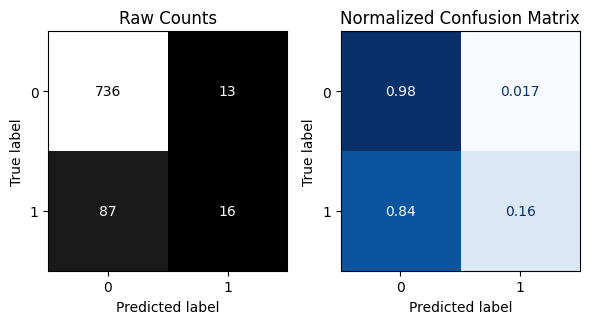


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       251
           1       0.20      0.03      0.05        34

    accuracy                           0.87       285
   macro avg       0.54      0.51      0.49       285
weighted avg       0.80      0.87      0.83       285



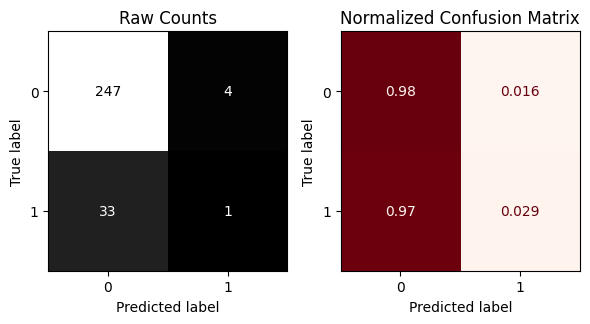

In [90]:
evaluate_classification(logreg_pipe, X_train_tf, y_train, X_test_tf, y_test)

### Tuned model

In [91]:
logreg_pipe.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('logisticregression', LogisticRegression(max_iter=500, random_state=42))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(max_iter=500, random_state=42),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 500,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': 42,
 'logisticregression__solver': 'lbfgs',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False}

Defining parameter grid

In [92]:
# Params compatible with penality='elasticnet'
elasticnet_params = {'logisticregression__solver' : ['saga'],
                     'logisticregression__penalty' : ['elasticnet'],
                     'logisticregression__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                     'logisticregression__class_weight': ['balanced', None]}
# Params compatible with penality='l2'
l2_params = {'logisticregression__solver': ['lbfgs', 'liblinear', 'newton-cg',
                                            'newton-cholesky', 'sag', 'saga'],
                  'logisticregression__penalty' : ['l2'],
                  'logisticregression__C': [0.0001, 0.001, 0.01, 0.1,
                                            1, 10, 100, 1000],
                     'logisticregression__class_weight': ['balanced', None] }
# Params compatible with penality='l1'
l1_params = {'logisticregression__solver' : ['liblinear', 'saga'],
               'logisticregression__penalty' : ['l1'],
                'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                          10, 100, 1000],
                     'logisticregression__class_weight': ['balanced', None]}
# Params with no penality
none_params = {'logisticregression__solver' : ['lbfgs', 'newton-cg',
                                               'newton-cholesky', 'sag', 'saga'],
               'logisticregression__penalty' : [None],
                     'logisticregression__class_weight': ['balanced', None]}
# Now make a list of the param dictionaries
param_grid = [l2_params, l1_params, elasticnet_params, none_params]

In [93]:
# Instantiate GS with scoring = 'recall_macro' and return_train_score = True
gs = GridSearchCV(logreg_pipe, param_grid, verbose=True, n_jobs=-1,
                  return_train_score=True, scoring='recall_macro', error_score='raise')
# Fit the gridsearch on the training data
gs.fit(X_train_tf, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=500,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid=[{'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                    10, 100, 1000],
                          'logisticregression__class_weight': ['balanced',
                                                               None],
                          'logisticregression__penalty': ['l2'],
                          'logis...
                          'logisticregression__l1_ratio': [0, 0.1, 0.2, 0.3,
                                                           0.4, 0.5, 0.6, 0.7,
                                                           0.8, 0.9, 1],
                          'logisticregression__penalty': ['elasticnet'],
                          'logisticregression__solver': ['saga']},
                         {'logisticregression__class_weight': ['balanced',
                                                               None],
                          'logisticregression__penalty': [None],
                          'logisticregression__solver': ['lbfgs', 'newton-cg',
                                                         'newton-cholesky',
                                                         'sag', 'saga']}],
             return_train_score=True, scoring='recall_macro', verbose=True)

In [94]:
gs.best_params_

{'logisticregression__C': 0.01,
 'logisticregression__class_weight': 'balanced',
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'saga'}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.72      0.82       749
           1       0.29      0.84      0.43       103

    accuracy                           0.73       852
   macro avg       0.63      0.78      0.63       852
weighted avg       0.89      0.73      0.78       852



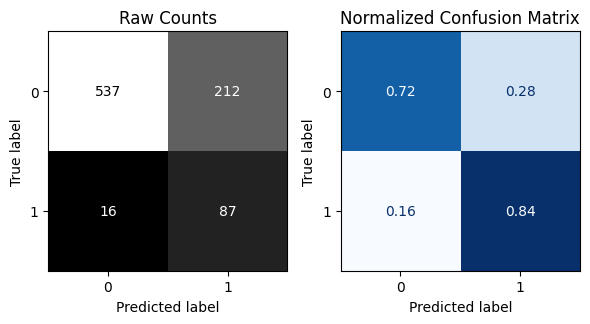


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.72      0.83       251
           1       0.29      0.85      0.43        34

    accuracy                           0.73       285
   macro avg       0.63      0.79      0.63       285
weighted avg       0.89      0.73      0.78       285



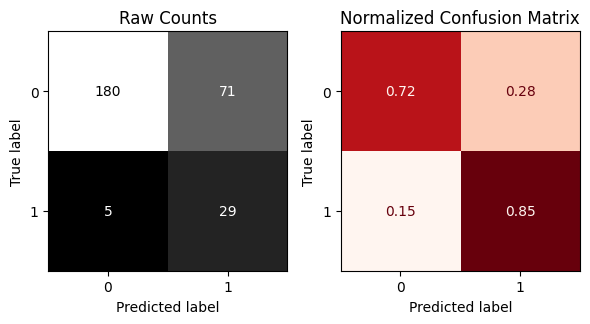

In [95]:
best_logreg = gs.best_estimator_
evaluate_classification(best_logreg, X_train_tf, y_train, X_test_tf, y_test)

### Question(s)

* Which combination of hyperparameters led to the best-tuned model?

>  ``` 'logisticregression__C': 0.01,
 'logisticregression__class_weight': 'balanced',
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'saga'



## K-Nearest Neighbors

### Default Model

In [96]:
y_train.value_counts(normalize=True)

stroke
0         0.879108
1         0.120892
dtype: float64

In [97]:
knn = KNeighborsClassifier()
knn_pipe = make_pipeline(scaler, knn)

In [98]:
knn_pipe.fit(X_train_tf, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       749
           1       0.59      0.16      0.25       103

    accuracy                           0.88       852
   macro avg       0.74      0.57      0.59       852
weighted avg       0.86      0.88      0.85       852



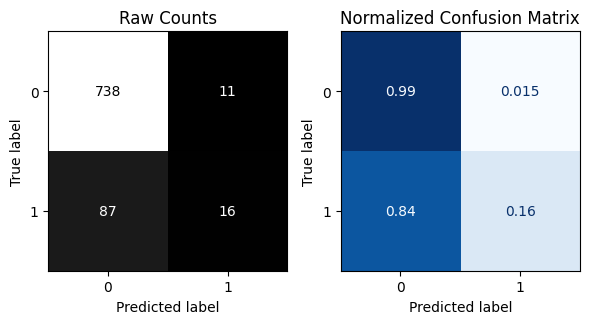


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       251
           1       0.00      0.00      0.00        34

    accuracy                           0.85       285
   macro avg       0.44      0.48      0.46       285
weighted avg       0.77      0.85      0.81       285



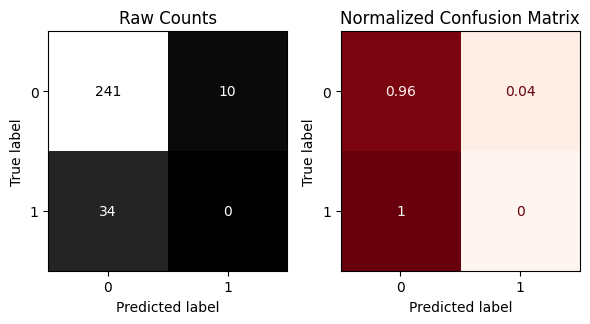

In [99]:
evaluate_classification(knn_pipe, X_train_tf, y_train, X_test_tf, y_test)

### Tuned Model

In [116]:
knn_pipe.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'kneighborsclassifier': KNeighborsClassifier(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

In [117]:
params = {
  'kneighborsclassifier__n_neighbors':list(range(1,50,2)),
  "kneighborsclassifier__algorithm":['auto', 'ball_tree', 'kd_tree', 'brute']
}

gs = GridSearchCV(knn_pipe, params, verbose=True, n_jobs=-1)
gs.fit(X_train_tf, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__algorithm': ['auto',
                                                             'ball_tree',
                                                             'kd_tree',
                                                             'brute'],
                         'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9,
                                                               11, 13, 15, 17,
                                                               19, 21, 23, 25,
                                                               27, 29, 31, 33,
                                                               35, 37, 39, 41,
                                                               43, 45, 47,
                                                               49]},
             verbose=True)

In [118]:
gs.best_params_

{'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__n_neighbors': 11}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       749
           1       0.67      0.10      0.17       103

    accuracy                           0.88       852
   macro avg       0.78      0.55      0.55       852
weighted avg       0.86      0.88      0.85       852



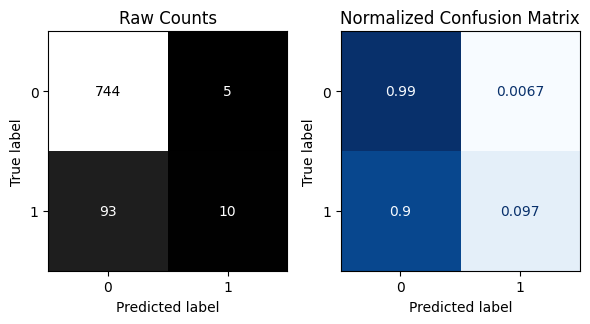


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       251
           1       0.00      0.00      0.00        34

    accuracy                           0.87       285
   macro avg       0.44      0.49      0.47       285
weighted avg       0.77      0.87      0.82       285



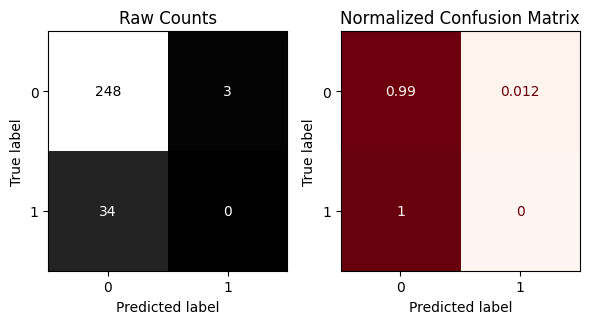

In [119]:
evaluate_classification(gs.best_estimator_, X_train_tf, y_train, X_test_tf, y_test)

### Question

* Which combination of hyperparameters led to the best-tuned model?
  - `{'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__n_neighbors': 11}`

## Random Forest

### Default Model

In [104]:
rf = RandomForestClassifier(random_state=42)
rf_pipe = make_pipeline(scalar, rf)

In [105]:
rf_pipe.fit(X_train_tf, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [ ]:
# evaluate_classification(rf_pipe, X_train, 0, X_test, y_test)
evaluate_classification(rf_pipe, X_train_tf, y_train, X_test_tf, y_test)

### Tuned Model

In [107]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('randomforestclassifier', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'randomforestclassifier': RandomForestClassifier(random_state=42),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestclassifier__n_estimators': 100,
 'randomfore

In [108]:
params = {'randomforestclassifier__max_depth': [None,10,15,20],
          'randomforestclassifier__n_estimators':[10,100,150,200],
          'randomforestclassifier__min_samples_leaf':[2,3,4],
          'randomforestclassifier__max_features':['sqrt','log2',None],
          'randomforestclassifier__oob_score':[True,False],
          }

In [110]:
gridsearch = GridSearchCV(rf_pipe, params, n_jobs=-1, cv=3, verbose=1)
gridsearch.fit(X_train_tf, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [None, 10, 15,
                                                               20],
                         'randomforestclassifier__max_features': ['sqrt',
                                                                  'log2',
                                                                  None],
                         'randomforestclassifier__min_samples_leaf': [2, 3, 4],
                         'randomforestclassifier__n_estimators': [10, 100, 150,
                                                                  200],
                         'randomforestclassifier__oob_score': [True, False]},
             verbose=1)

In [112]:
gridsearch.best_params_

{'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__min_samples_leaf': 4,
 'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__oob_score': True}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       749
           1       0.95      0.19      0.32       103

    accuracy                           0.90       852
   macro avg       0.93      0.60      0.63       852
weighted avg       0.91      0.90      0.87       852



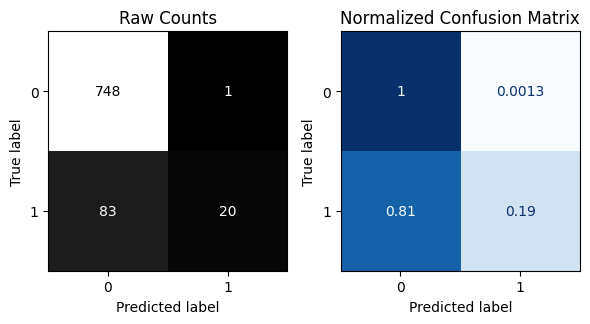


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       251
           1       0.50      0.03      0.06        34

    accuracy                           0.88       285
   macro avg       0.69      0.51      0.50       285
weighted avg       0.84      0.88      0.83       285



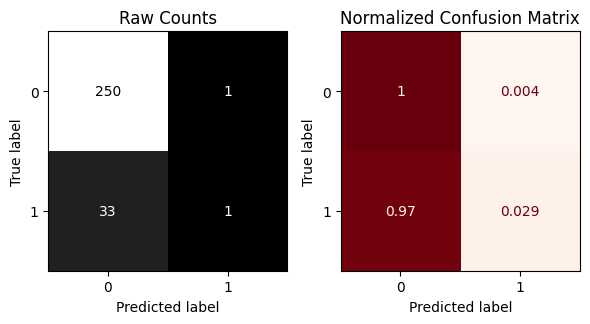

In [115]:
evaluate_classification(gridsearch.best_estimator_, X_train_tf, y_train, X_test_tf, y_test)

### Question

* Which combination of hyperparameters led to the best-tuned model?

* `{'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__min_samples_leaf': 4,
 'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__oob_score': True}`

## Question

  * Which of your models would you recommend for production? Which metric or metrics did you use to decide that, and why?
    - I recommend the tuned Logistic Regression model, because it significantly outperformed the other two at detecting positive stroke patients (79% of strokes correctly identified vs 60% and 51% for the other two models.